# Importing Libraries

In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from cv2 import imshow
import scipy.sparse as SC
import scipy.sparse.linalg as linalg

# Defining functions

In [2]:
#1. Selecting cooridinates on our images

points=[] # holds the values of the selected coordinates
def mousepoints(events,x, y,flags,parameters):
    global points
    
    if events==cv2.EVENT_LBUTTONDOWN: 
       # print(x,y)
        # points[counter]=x,y
        # counter= counter + 1

        points.append((x,y))
        

        #print(points)

    return

#dest_image =cv2.imread(r"C:\Users\gakin\OneDrive\Programming practice\COMP0026 Coursework(IP)\Test Images\space.jpg")


def get_omega(im):
    global points

    cv2.imshow("Please Click on image to get ROI points",im)
    cv2.setMouseCallback("Please Click on image to get ROI points", mousepoints)
    cv2.waitKey(0)


    #print(points)

    #points=np.asarray(points)

    photo = im.copy() # making a copy of our image for visulalisation
    new_img=cv2.polylines(photo, np.int32([points]), isClosed=True, color=(0,0,255),thickness=4) # draw a polygon of our region of interest

    # cv2.imshow("new image",new_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    return points, photo, new_img

#Om=get_omega(dest_image)

# cv2.imshow("new image",Om[2])
# cv2.waitKey(0)
# cv2.destroyAllWindows()



In [3]:

#2. funtcion to create mask of ROI 
def create_mask(Image, points):


    
    ph=Image.shape
    mask=np.zeros((ph[0],ph[1]), dtype="uint8")



    cv2.fillConvexPoly(mask,np.int32([points]),255)


    cop=Image.copy()
    
    masked_image= cv2.fillConvexPoly(cop,np.int32([points]),0)
    #masked_image = cv2.inpaint(Image, mask, 2, cv2.INPAINT_NS)
   # masked_image= cv2.bitwise_and(mask,Image)

    return mask,masked_image




In [4]:
#3 Function to find the indices of the ROI of the mask
def ROI_points(mask):
    
    non0= np.nonzero(mask)
    list_points=list(zip(non0[0],non0[1]))
    #i,index= enumerate(list_points)

    return list_points


In [5]:
#4 function to get the 4 neighbours surrounding a pixel
def surrounding_pixels(index):
    i,j=index

    value=[(i+1,j), (i-1,j),(i,j+1),(i,j-1)]
    return value

In [6]:
#5. used to determine if pixel index is inside ROI 
def in_omega(index, mask):
    return mask[index] == 1

In [7]:
#6  Function to make cooefficient matrix(The sparse A matrix)

def sparse_matrix(Indices):

  m=len(Indices)

  A_Mat=SC.lil_matrix((m,m))
  for i, index in enumerate(Indices):
    A_Mat[i,i]=4

    for x in surrounding_pixels(index):
      if x not in Indices:
        continue
      j=Indices.index(x)
      A_Mat[i,j]=-1
    
  return A_Mat

In [8]:
#7 Computes compute the laplacian of the ROI
def laplace(src,index):
    i, j= index
    value= (4*src[i,j])-(1 * src[i + 1, j]) - (1 * src[i - 1, j]) - (1 * src[i, j + 1]) - (
                1 * src[i, j - 1])
   
    return value   


# 8 Checking if pixel index is on the edge

def pixel_location(index, mask):
    if not np.any(in_omega(index,mask)):
        return False
    for pix in surrounding_pixels(index):
        if not np.any(in_omega(pix,mask)):
            return True

    return False
    


In [9]:
#9 function to calculate the gradient of pixels inside ROI

def gradient(im,index):
    i,j=index

    right = 1* (im[i+1,j])
    left = -1 * (im[i-1,j])
    down = 1 * (im[i,j+1])
    up = -1 * (im[i,j-1])

   

    value=right+left+down+up

    return value
    



# 1. Filling

In [17]:
#Please click on the image to generate the mask

source_path=r"inputs\1.filling\hope.jpg" #https://www.joom.com/en/products/5bc6eb7c28fc710198a726a1
target_path=r"inputs\1.filling\Me.jpg" #https://unsplash.com/images/nature/space

src= cv2.imread(source_path,cv2.IMREAD_GRAYSCALE)
target=cv2.imread(target_path,cv2.IMREAD_GRAYSCALE)

# resizing the images because the larger the images the more time it takes for the A matrix to computed
src= cv2.resize(src,(200,150))
target=cv2.resize(target,(200,150))

points.clear()#clearing the list to put new values

boundary=get_omega(target)
mask=create_mask(target,boundary[0])




cv2.imshow("src mask",mask[0])# show created mask
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite(r"inputs\1.filling\fill mask.jpg", mask[0]) # Save mask into same path as src and target


True

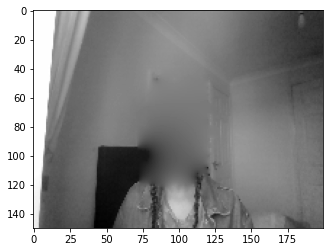

In [18]:

def fill(src,target,mask):

    Indicies=ROI_points(mask)
    A_Mat=sparse_matrix(Indicies)
    M= len(Indicies)
    
    B_Mat= np.zeros(M) # This is the B matrix
    
    for i, index in enumerate(Indicies):
        
        B_Mat[i]=laplace(src,index)

        if pixel_location(index,mask): #checking if pixel is on the boundary
            for pixels in surrounding_pixels(index): #the surrounding pixels
                if not np.any(in_omega(pixels,mask)): # pixels npt in ROI
                    B_Mat[i] += target[pixels]

    x=linalg.cg(A_Mat,B_Mat) #solve for x to get new pixels
    new_image=np.copy(target).astype(int)
    for i, index in enumerate(Indicies):
        new_image[index]=x[0][i]

    return new_image



mask=cv2.imread(r"inputs\1.filling\fill mask.jpg")
if __name__ == '__main__':
    mask=mask.astype(np.float64)/255
    mask[mask !=1] =0

    new_image=[fill(src,target,mask)]
    new=cv2.merge(new_image)
    new = new.astype(np.uint8)

    #new= cv2.imwrite(r"Results\1.filling\output.jpg", new)

    # cv2.imshow("New Image",new)
    # cv2.waitKey(0)
    plt.imshow(new, cmap="gray")
    
    

# 2a. Seamless Cloning 

In [19]:
#Please click on the image to generate the mask

source_path=r"inputs\2.seamless cloning\a. seamless\catt.jpeg" #https://www.joom.com/en/products/5bc6eb7c28fc710198a726a1
target_path=r"inputs\2.seamless cloning\a. seamless\space2.jpg" #https://unsplash.com/images/nature/space

src= cv2.imread(source_path,cv2.IMREAD_GRAYSCALE)
target=cv2.imread(target_path,cv2.IMREAD_GRAYSCALE)

# resizing the images because the larger the images the more time it takes for the A matrix to computed
src= cv2.resize(src,(200,150))
target=cv2.resize(target,(200,150))

points.clear()#clearing the list to put new values
boundary=get_omega(src) #Please click on the image to generate the mask
src_mask=create_mask(src,boundary[0])


cv2.imshow("src mask",src_mask[0])# show created mask
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite(r"inputs\2.seamless cloning\a. seamless\source mask.jpg", src_mask[0]) # Save mask into same path as src and target


True

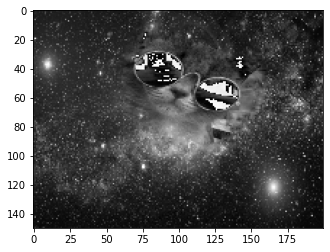

In [20]:

#Performing the poisson method with all the fuctions together
def seamless_cloning(src,target,mask):

    Indicies=ROI_points(mask)
    A_Mat=sparse_matrix(Indicies)
    M= len(Indicies)
    
    B_Mat= np.zeros(M) # This is the B matrix
    
    for i, index in enumerate(Indicies):
        
        B_Mat[i]=laplace(src,index)

        if pixel_location(index,mask): #checking if pixel is on the boundary
            for pixels in surrounding_pixels(index): #the surrounding pixels
                if not np.any(in_omega(pixels,mask)): # pixels npt in ROI
                    B_Mat[i] += target[pixels]

    x=linalg.cg(A_Mat,B_Mat) #solve for x to get new pixels
    new_image=np.copy(target).astype(int)
    for i, index in enumerate(Indicies):
        new_image[index]=x[0][i]

    return new_image

mask=cv2.imread(r"inputs\2.seamless cloning\a. seamless\source mask.jpg")
if __name__ == '__main__':
    mask=mask.astype(np.float64)/255
    mask[mask !=1] =0

    mask=mask[:,:,0]

    new_image=[seamless_cloning(src,target,mask)]
    new=cv2.merge(new_image)
    new = new.astype(np.uint8)

    #new= cv2.imwrite(r"Results\2. cloning\a.seamless.jpg", new)
    plt.imshow(new, cmap="gray")

    



## 2b. Mixed gradients

In [21]:
#Please click on the image to generate the mask

source_path=r"inputs\2.seamless cloning\b.Mixed\OG src.png" 
target_path=r"inputs\2.seamless cloning\b.Mixed\OG brick.png" #https://motionarray.com/stock-photos/empty-interior-with-red-brick-wall-357642/
src= cv2.imread(source_path,cv2.IMREAD_GRAYSCALE)
target=cv2.imread(target_path,cv2.IMREAD_GRAYSCALE)

# resizing the images because the larger the images the more time it takes for the A matrix to computed
src= cv2.resize(src,(400,250))
target=cv2.resize(target,(400,250))

points.clear()#clearing the list to put new values
boundary=get_omega(src)
src_mask=create_mask(src,boundary[0])


cv2.imshow("src mask",src_mask[0])# show created mask
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite(r"inputs\2.seamless cloning\b.Mixed\mixed gradient_m.jpg", src_mask[0]) # Save mask into same path as src and target


True

In [23]:
#using the same method as seamless but now we compute the gradient of target and source
#we then check which of the gradients are greater


def Mixed_Gardients(src,target,mask):

    Indicies=ROI_points(mask)
    A_Mat=sparse_matrix(Indicies)
    M= len(Indicies)
    
    B_Mat= np.zeros(M) # This is the B matrix
    
    
    for i, index in enumerate(Indicies):

        gradient_src=gradient(src,index)
        gradient_target=gradient(target,index)

        if gradient_src>gradient_target:
            im=src

        else:
            im=target
        
        B_Mat[i]=laplace(im,index)

        if pixel_location(index,mask): #checking if pixel is on the boundary
            for pixels in surrounding_pixels(index): #the surrounding pixels
                if not np.any(in_omega(pixels,mask)): # pixels npt in ROI
                    B_Mat[i] += target[pixels]

    x=linalg.cg(A_Mat,B_Mat) #solve for x to get new pixels
    new_image=np.copy(target).astype(int)
    for i, index in enumerate(Indicies):
        new_image[index]=x[0][i]

    return new_image


if __name__ == '__main__':

    Mask= cv2.imread(r"inputs\2.seamless cloning\b.Mixed\mixed gradient_m.jpg")
    mask = Mask.astype(np.float64) / 255
    mask[mask != 1] = 0

    mask = mask[:,:,0]

    
    mixed_G = [Mixed_Gardients(src, target, mask) ]
    mixed_G=cv2.merge(mixed_G)
    new_G= mixed_G.astype(np.uint8)

    #cv2.imwrite(r"Results\2. cloning\b.Mixed.jpg",new_G)
    plt.imshow(new_G, cmap="gray")

KeyboardInterrupt: 

# 3. Seamless cloning for Colour images 

In [24]:
#Please click on the image to generate the mask

source_path=r"inputs\3.coloured imaged\catt.jpeg" #https://www.joom.com/en/products/5bc6eb7c28fc710198a726a1
target_path=r"inputs\3.coloured imaged\space2.jpg" #https://unsplash.com/images/nature/space
src= cv2.imread(source_path)
target=cv2.imread(target_path)

# resizing the images because the larger the images the more time it takes for the A matrix to computed
src= cv2.resize(src,(200,150))
target=cv2.resize(target,(200,150))

points.clear()#clearing the list to put new values
boundary=get_omega(src)
src_mask=create_mask(src,boundary[0])


cv2.imshow("src mask",src_mask[0])# show created mask
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite(r"inputs\3.coloured imaged\colour_mask.jpg", src_mask[0]) # Save mask into same path as src and target


True

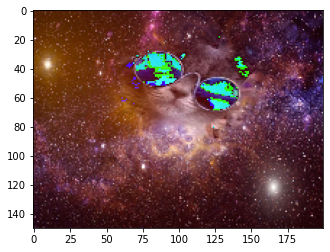

In [25]:


if __name__ == '__main__':

    Mask= cv2.imread(r"inputs\3.coloured imaged\colour_mask.jpg")
    mask = Mask.astype(np.float64) / 255
    mask[mask != 1] = 0

    mask = mask[:,:,0]

    channels=src.shape[-1]
    
    coloured_Im = [seamless_cloning(src[:, :,i], target[:, :,i], mask) for i in range(channels) ]
    coloured_Im=cv2.merge(coloured_Im)
    new_C= coloured_Im.astype(np.uint8)

    #cv2.imwrite(r"Results\3.coloured imaged\output.jpg",new_C)

    # cv2.imshow("New Image",new_C)
    # cv2.waitKey(0)
    plt.imshow(new_C)

# 4. Texture Flattening

In [26]:
#Please click on the image to generate the mask

source_path=r"inputs\4.Texture\image3.jpg" #https://fineartamerica.com/featured/pirate-ship-sunset-daniel-eskridge.html
target_path=r"inputs\4.Texture\image3.jpg" #https://www.tomorrow.io/weather/blog/cloud-classifications/

src= cv2.imread(source_path)
target=cv2.imread(target_path)

# resizing the images because the larger the images the more time it takes for the A matrix to computed
src= cv2.resize(src,(200,150))
target=cv2.resize(target,(200,150))

points.clear()#clearing the list to put new values
boundary=get_omega(src)
src_mask=create_mask(src,boundary[0])


cv2.imshow("src mask",src_mask[0])# show created mask
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite(r"inputs\4.Texture\texture_m.jpg", src_mask[0]) # Save mask into same path as src and target


True

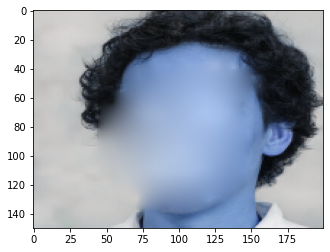

In [27]:
#Works by thresholding the generated Laplacian

def texture(src,target,mask):

    Indicies=ROI_points(mask)
    A_Mat=sparse_matrix(Indicies)
    M= len(Indicies)
    
    B_Mat= np.zeros(M) # This is the B matrix
    
    for i, index in enumerate(Indicies):
        
        B_Mat[i]=laplace(src,index)
        retval, B_Mat[i]= cv2.threshold(np.array(B_Mat[i]), 25, 1, cv2.THRESH_BINARY)


        if pixel_location(index,mask): #checking if pixel is on the boundary
            for pixels in surrounding_pixels(index): #the surrounding pixels
                if not np.any(in_omega(pixels,mask)): # pixels npt in ROI
                    B_Mat[i] += target[pixels]

    x=linalg.cg(A_Mat,B_Mat) #solve for x to get new pixels
    new_image=np.copy(target).astype(int)
    for i, index in enumerate(Indicies):
        new_image[index]=x[0][i]

    return new_image




if __name__ == '__main__':

    Mask= cv2.imread(r"inputs\4.Texture\texture_m.jpg")

    
    mask = Mask.astype(np.float64) / 255
    mask[mask != 1] = 0
    mask = mask[:,:,0]

    channels=src.shape[-1]
        
    text_Im = [texture(src[:, :,i], target[:, :,i], mask) for i in range(channels) ]
    text_Im=cv2.merge(text_Im)
    new_tex= text_Im.astype(np.uint8)

    #cv2.imwrite(r"Results\4.Texture\new_tex.jpg",new_tex)
    plt.imshow(new_tex)
    
        